In [1]:
import sys
sys.path.append("../")
from utils import transform_image_to_kspace, transform_kspace_to_image
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
import pydicom
from skimage.draw import line
import nibabel as nib
import torch
import torchkbnufft as tkbn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#data_path = r'C:\from SSD\fastMRI_brain_DICOM\100099070170\279.dcm'
data_path = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM\300008311232\808.dcm'
data = pydicom.dcmread(data_path)

image = data.pixel_array
if (np.shape(image) != (320, 320)):
    image = cv2.resize(image, (320, 320))

image = (image - np.mean(image)) / np.std(image)

#kspace = transform_image_to_kspace(image)

In [2]:
def c2h(X):
    # Convert cartesian to homogeneous coordinates.
    # Input:
    # X - cartesian coordinates
    # Output:
    # Xh - homogeneous coordinates

    n = np.ones([1,X.shape[1]])
    Xh = np.concatenate((X,n))

    return Xh

def t2h(T, t):
    # Convert a 2D transformation matrix to homogeneous form.
    # Input:
    # T - 2D transformation matrix
    # t - 2D translation vector
    # Output:
    # Th - homogeneous transformation matrix

    T1 = np.concatenate((T,t[:,None]),axis=1)
    n = np.zeros([1,T1.shape[1]])
    n[-1,-1] = 1
    Th = np.append(T1, n, axis=0)
    
    return Th

def rotate(phi):
    # 2D rotation matrix.
    # Input:
    # phi - rotation angle
    # Output:
    # T - transformation matrix

    T = np.array([[np.cos(phi), -np.sin(phi)],
                  [np.sin(phi), np.cos(phi)]])
    
    return T

def image_transform(I, Th):
    # Image transformation by inverse mapping.
    # Input:
    # I - image to be transformed
    # Th - homogeneous transformation matrix
    # output_shape - size of the output image (default is same size as input)
    # Output:
    # It - transformed image
    # Xt - remapped coordinates

    # output size is same as input
    output_shape = I.shape

    # spatial coordinates of the transformed image
    x = np.arange(0, output_shape[1])
    y = np.arange(0, output_shape[0])
    xx, yy = np.meshgrid(x, y)

    # convert to a 2-by-p matrix (p is the number of pixels)
    X = np.concatenate((xx.reshape((1, xx.size)), yy.reshape((1, yy.size))))
    # convert to homogeneous coordinates
    Xh = c2h(X)

    # perform inverse coordinates mapping
    T_inv = np.linalg.pinv(Th)
    Xt = T_inv.dot(Xh) 
    It = ndimage.map_coordinates(I, [Xt[1,:], Xt[0,:]], order=1, mode='constant').reshape(output_shape)

    return It, Xt

def image_transform_test(I, ang_deg, trans_x, trans_y):

    # rotation around the image center
    centre = int(I.shape[0]/2)
    ang_rad = np.deg2rad(ang_deg)
    T_1 = t2h(np.eye(2), centre*np.ones(2))
    T_2 = t2h(rotate(ang_rad), np.zeros(2))
    T_3 = t2h(np.eye(2), -centre*np.ones(2))
    T_rot = T_1.dot(T_2).dot(T_3)

    # translation
    T_trans = t2h(np.eye(2), np.array([trans_x, trans_y]))
    
    # combine transforms
    T_tot = T_trans.dot(T_rot)
    
    It, Xt = image_transform(I, T_tot)
    
    return It, Xt

In [3]:
from scipy import ndimage

def rigid_motion(image, n_movements, ang_std, trans_std, pe_direction):
    # normalize image between 0 and 1
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    
    # generate movement parameters
    grid_size = image.shape
    locs = np.sort(np.random.permutation(grid_size[0])[:n_movements])g
    ang = np.random.normal(0, ang_std, (n_movements+1))
    trans_x = np.random.normal(0, trans_std, (n_movements+1))
    trans_y = np.random.normal(0, trans_std, (n_movements+1))
    
    # initiate k-space and parameters
    k_space = transform_image_to_kspace(image)    
    ang_tot = ang[0]
    trans_x_tot = trans_x[0]
    trans_y_tot = trans_y[0]
    
    # add first movement to k-space
    It_0, Xt_0 = image_transform_test(image, ang_tot, trans_x_tot, trans_y_tot)
    kspace_It_0 = transform_image_to_kspace(It_0)
    if (pe_direction == "horizontal"):
        k_space[:locs[0], :] = kspace_It_0[:locs[0], :]
    elif (pe_direction == "vertical"):
        k_space[:, :locs[0]] = kspace_It_0[:, :locs[0]]
    
    # add middle movements to k-space
    for i in range(n_movements):
        ang_tot += ang[i+1]
        trans_x_tot += trans_x[i+1]
        trans_y_tot += trans_y[i+1]
        It_i, Xt_i = image_transform_test(image, ang_tot, trans_x_tot, trans_y_tot)
        kspace_It_i = transform_image_to_kspace(It_i)
        if i < n_movements:
            if (pe_direction == "horizontal"):
                k_space[locs[i-1]:locs[i], :] = kspace_It_i[locs[i-1]:locs[i], :]
            elif (pe_direction == "vertical"):
                k_space[:, locs[i-1]:locs[i]] = kspace_It_i[:, locs[i-1]:locs[i]] 
        elif i == n_movements:
            if (pe_direction == "horizontal"):
                k_space[locs[i-1]:, :] = kspace_It_i[locs[i-1]:, :]
            elif (pe_direction == "vertical"):
                k_space[:, locs[i-1]:] = kspace_It_i[:, locs[i-1]:] 
                
    img = transform_kspace_to_image(k_space)
    img = (img - np.mean(img)) / np.std(img)
    
    return img

[217]


(-0.5, 319.5, 319.5, -0.5)

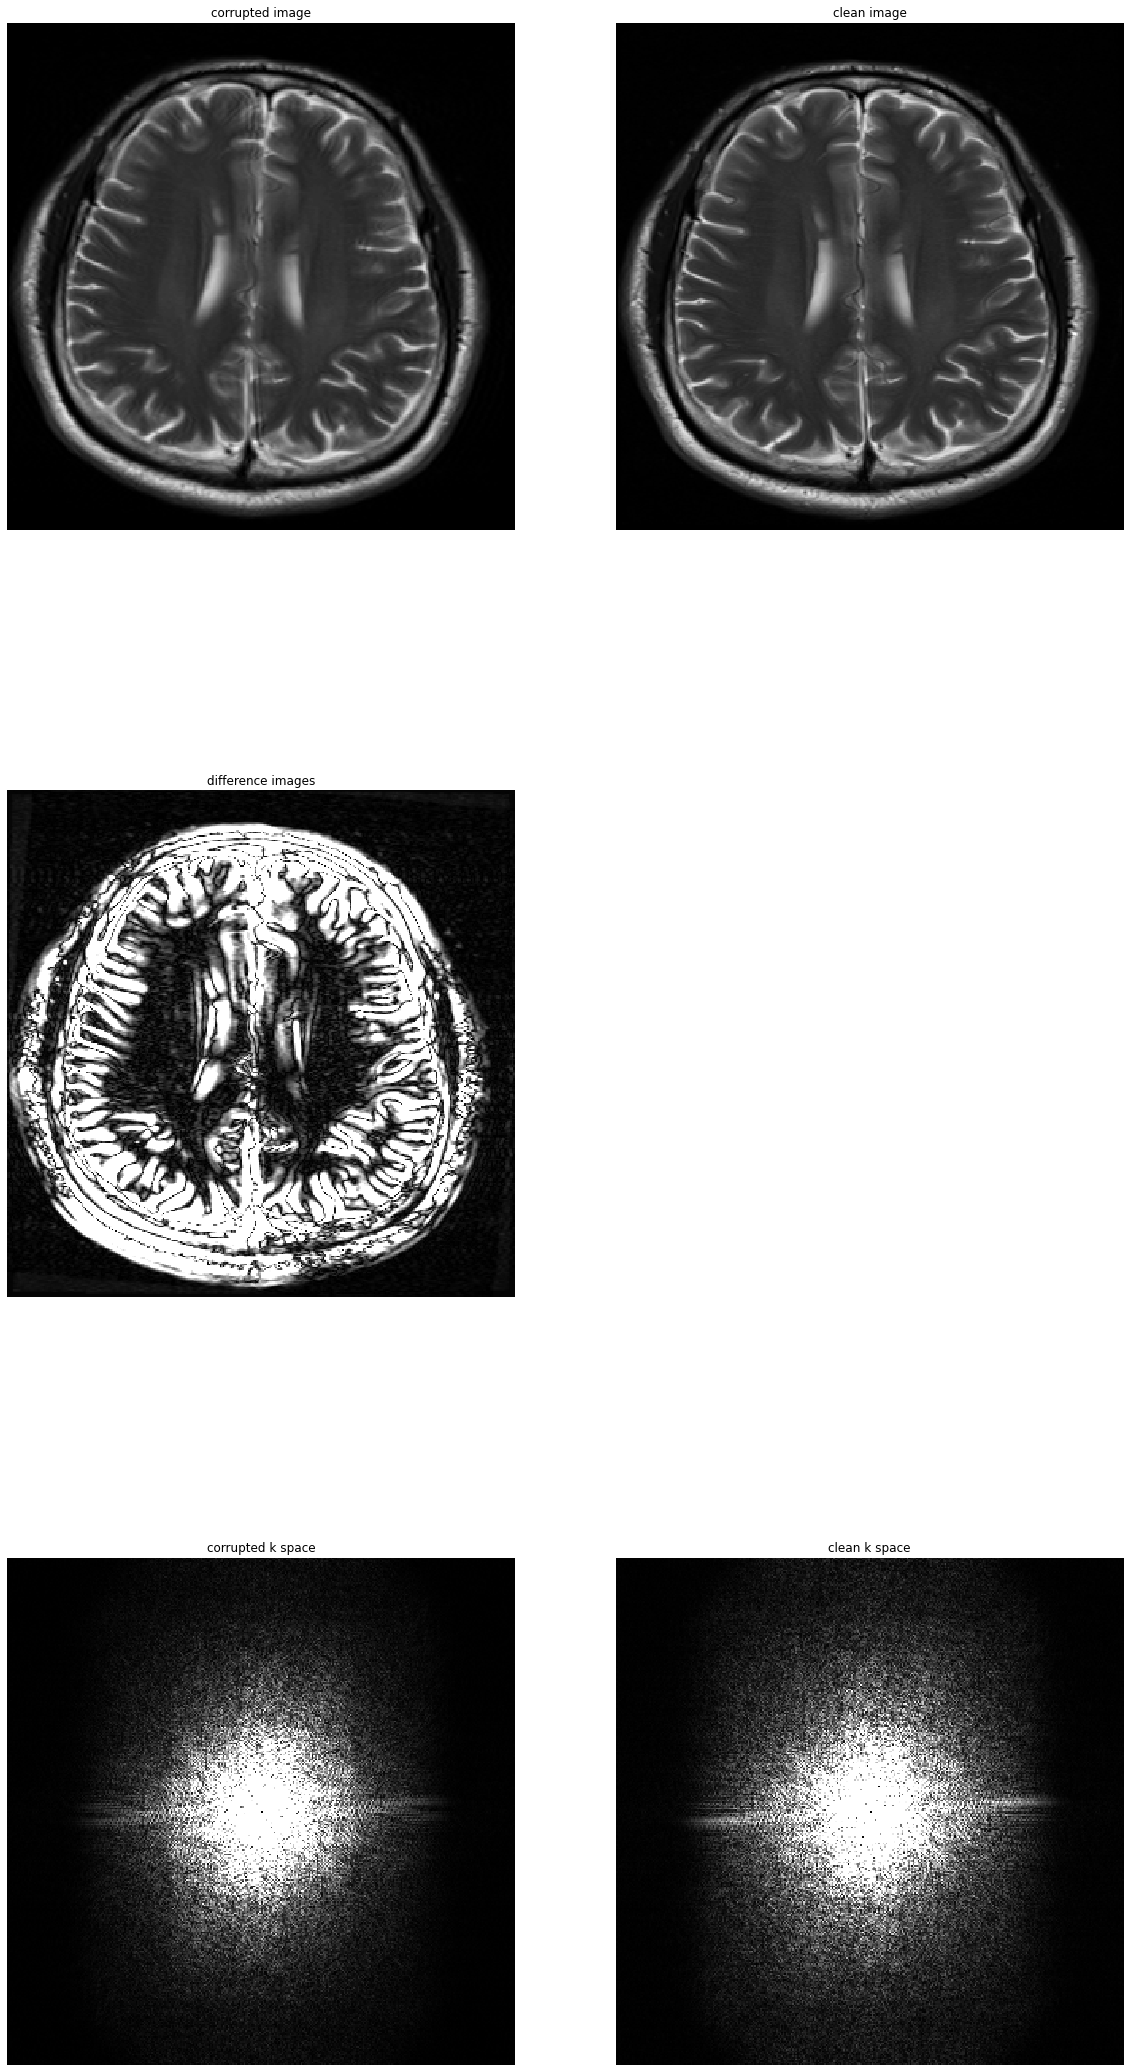

In [4]:
# plotting
pe_direction = random.choice(["horizontal", "vertical"])
img = rigid_motion(image, 1, 2.5, 2.5, pe_direction)

hr = image
lr = img

k_lr = np.abs(transform_image_to_kspace(lr))
k_hr = np.abs(transform_image_to_kspace(hr))

k_lr = k_lr / np.max(np.abs(k_lr))
k_hr = k_hr / np.max(np.abs(k_hr))

lr = (lr - np.mean(lr)) / np.std(lr)
hr = (hr - np.mean(hr)) / np.std(hr)

vmx = np.max(hr)
vmn = np.min(hr)
dmx = 0.5
kmx = 0.01

fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(3, 2, 1)
ax.imshow(lr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("corrupted image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 2)
ax.imshow(hr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("clean image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 3)
ax.imshow(np.abs(lr - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.set_title("difference images")
ax.axis('off')
ax = fig.add_subplot(3, 2, 5)
ax.imshow(k_lr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("corrupted k space")
ax.axis('off')
ax = fig.add_subplot(3, 2, 6)
ax.imshow(k_hr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("clean k space")
ax.axis('off')

In [5]:
from sklearn.metrics import mean_squared_error
mean_squared_error(image, img)

0.39538577071113107

In [6]:
# the artefacts should be well-balanced in terms of MSE

import os
from sklearn.metrics import mean_squared_error

images_path_list = []
main_path = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM'
folders = os.listdir(main_path)
for folder in folders:
    folder_path = main_path + '/' + folder
    images = os.listdir(folder_path)
    for image in images:
        image_path = folder_path + '/' + image
        images_path_list.append(image_path)

error_motion_image_total = []

for image_path in images_path_list:
    
    data = pydicom.dcmread(image_path)
    image = data.pixel_array   
    if (np.shape(image) != (320, 320)):
        image = cv2.resize(image, (320, 320))  
    image = (image - np.mean(image)) / np.std(image)
    
    for i in range(1):
        
        img_motion = rigid_motion(image, 1, 2.5, 2.5, pe_direction)
        error_motion_image = mean_squared_error(image, img_motion)
        error_motion_image_total.append(error_motion_image)

print('average motion image error: {}'.format(sum(error_motion_image_total)/len(error_motion_image_total)))

[138]
[90]
[81]
[244]
[98]
[177]
[259]
[107]
[34]
[141]
[40]
[143]
[33]
[191]
[196]
[205]
[113]
[164]
[140]
[111]
[180]
[87]
[4]
[7]
[289]
[15]
[270]
[38]
[311]
[131]
[281]
[20]
[29]
[281]
[245]
[21]
[293]
[188]
[307]
[196]
[29]
[254]
[205]
[53]
[182]
[9]
[108]
[74]
[95]
[302]
[70]
[261]
[228]
[20]
[295]
[316]
[68]
[212]
[1]
[261]
[84]
[241]
[306]
[117]
[255]
[105]
[215]
[162]
[225]
[219]
[7]
[243]
[316]
[43]
[236]
[146]
[120]
[221]
[227]
[96]
[263]
[187]
[14]
[61]
[165]
[122]
[220]
[295]
[256]
[200]
[221]
[290]
[274]
[224]
[283]
[210]
average motion image error: 0.1314166389612865
